### Auto Regressive Integratred Moving Average (ARIMA) Model
ARIMA model can be used to predict the future values based on its own past values, that is, its own lags (Auto Regressive)  and the lagged forecast errors (Moving Average). [Complete Guide in this link](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values)

Here we use it for forecasting stock price with the same dataset used in the xgboost for time series forecasting in another notebook in this repository.

#### Importing Extensions and  main Libraries
I will be importing libraries in the notebook cell as needed to make it clear where it is exactly needed.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

In [4]:
# data is microsoft's past 5 year daily stock price (April 10 2020 - April 10 2021)
data_url = "https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1460246400&period2=1618012800&interval=1d&events=history&includeAdjustedClose=true"
data = pd.read_csv(data_url)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-11,54.490002,55.150002,54.299999,54.310001,49.800735,21414200
1,2016-04-12,54.369999,54.779999,53.759998,54.650002,50.112518,24944300
2,2016-04-13,55.119999,55.439999,54.889999,55.349998,50.754379,20818000
3,2016-04-14,55.220001,55.580002,55.070000,55.360001,50.763554,20877100
4,2016-04-15,55.299999,55.919998,55.110001,55.650002,51.029476,28793800
...,...,...,...,...,...,...,...
1254,2021-04-05,242.759995,249.960007,242.699997,249.070007,249.070007,36910600
1255,2021-04-06,247.610001,249.399994,246.880005,247.860001,247.860001,22931900
1256,2021-04-07,247.809998,250.929993,247.190002,249.899994,249.899994,22719800
1257,2021-04-08,252.770004,254.139999,252.000000,253.250000,253.250000,23625200


In [6]:
# making it univariate time series problem, we are taking the Closing price to predict
df = data[["Close"]].round(2).copy()
print(df.shape)
df.head()

(1259, 1)


,Close
0,54.31
1,54.65
2,55.35
3,55.36
4,55.65


In [7]:
df.describe()

,Close
count,1259.000000
mean,120.070731
std,55.604813
min,48.430000
25%,71.860000
50%,106.810000
75%,154.975000
max,255.850000


##### ARIMA model is characterized by 3 terms: p,d and q
- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

**If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’**

#### lets find d first
- The purpose of differencing is to make the time series stationary. Differencing is only needed if the series is non-stationary.
- [Augmented Dickey Fuller (ADF)](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) can be used to check if the series is stationary or not. 
- The null hypothesis of the **ADF test** is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary. So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [10]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.4095749174929415
p-value: 0.9971572080691912


Since, the values is greater, lets difference the series and see how the auto-correlation plot looks like using **Autocorrelation Function (ACF)**

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

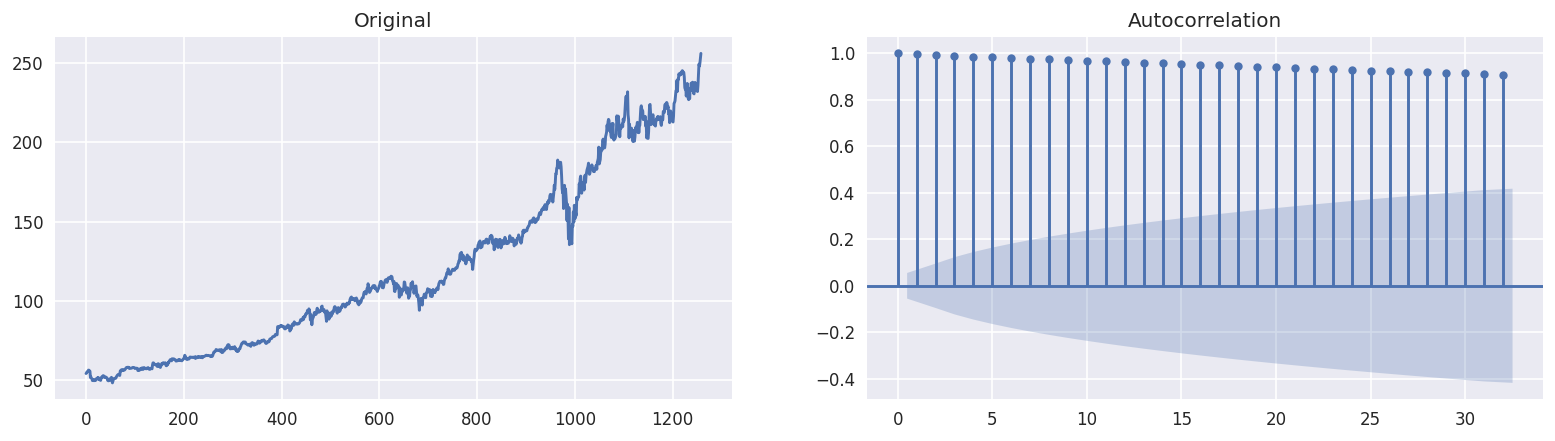

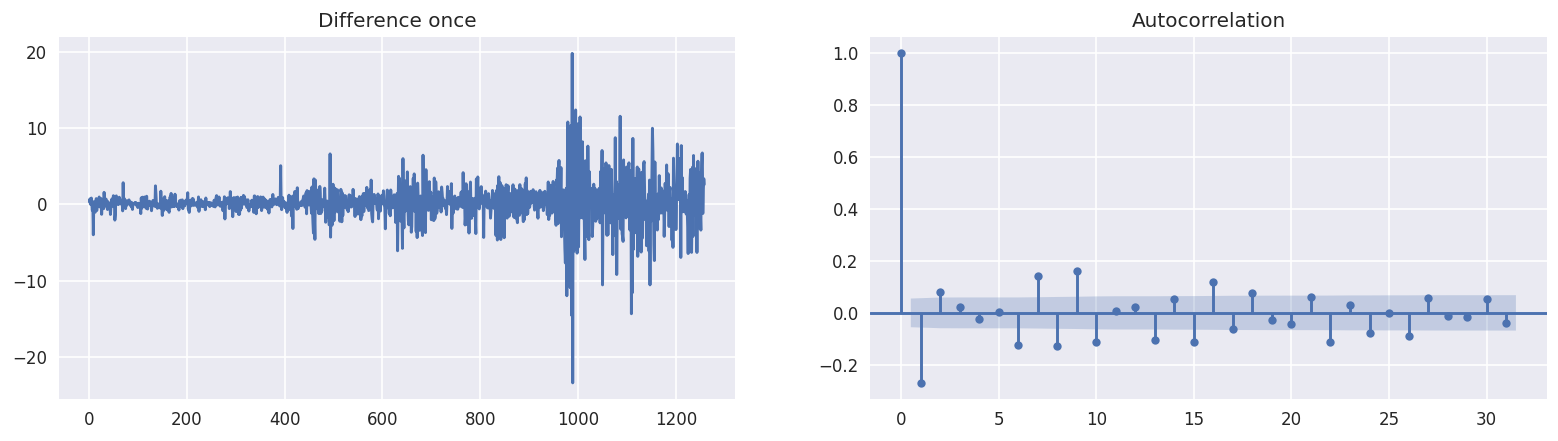

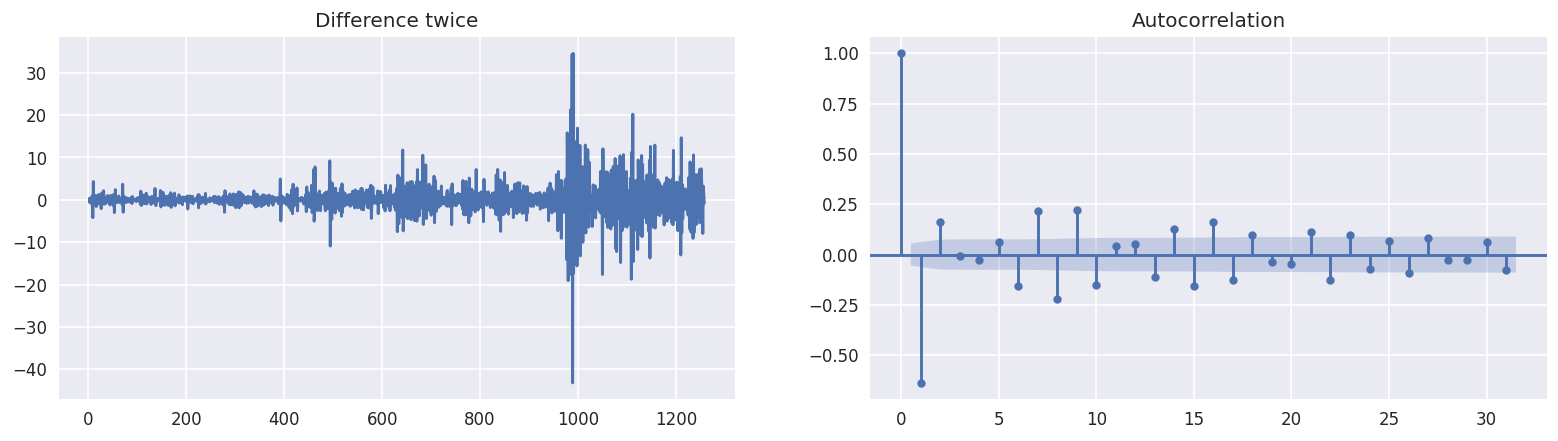

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

# 1st Differencing
diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

# 2nd Differencing
diff = df.Close.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

It can be difficult to analyze the plot, so lets use `pmdarima package` to get the number of indexing. [pmdarima docs](http://alkaline-ml.com/pmdarima/modules/classes.html)

In [15]:
from pmdarima.arima.utils import ndiffs

ndiffs(df.Close, test="adf")

1

Ok, so according to pmdarima, lets use the value of d as 1.